dataset: https://www.kaggle.com/splcher/animefacedataset (download and extract to ./images)
guide: https://avandekleut.github.io/vae/

## TODO
- [ ] More powerful network (convnet) so it can learn from the full dataset
- [ ] Variational autoencoder for better decoding
- [ ] Analyze the manifold compressed anime faces inhabit in highe

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import torch; torch.manual_seed(0)
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import torchvision.transforms as transforms

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from torchvision.io import read_image
import os

class RawImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_filenames = os.listdir('images')
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_filenames[idx])
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [6]:
img_shape = (3, 64, 64)
# TODO: Filter in dataset creation (then its in memory, all good)
dataset = RawImageDataset('./images', transform=transforms.Compose([
    transforms.CenterCrop(img_shape[1:]),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(0, 1),
]))


data = DataLoader(dataset, batch_size=64, shuffle=True)

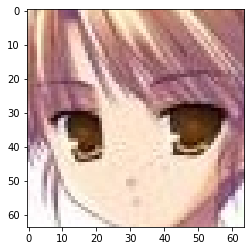

In [7]:
def imshow(img): plt.imshow(img.permute(1,2,0))
imshow(dataset[3])

In [8]:
flattened_img_params = img_shape[0]*img_shape[1]*img_shape[2]

In [9]:
flattened_img_params

12288

In [10]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(flattened_img_params, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)



In [11]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, flattened_img_params)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape(-1, *img_shape)


In [12]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [13]:
latent_dims=2

In [14]:
autoencoder = Autoencoder(latent_dims).to(device)

In [15]:
from tqdm.notebook import tqdm

In [16]:
def train(autoencoder, data, epochs=5):
    optim = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x in tqdm(data):
            x = x.to(device)
            optim.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            optim.step()
            print('loss', loss.item(), end=' '*30 + '\r')
        print('epoch', epoch, end=' '*30 + '\n')
        
        
# network is not powerful enough to learn full data
#train(autoencoder, data)

In [ ]:
optim = torch.optim.Adam(autoencoder.parameters())

In [57]:
# overfit to a single minibatch

x = next(iter(data))

losses = []
for epoch in tqdm(range(3000)):
    x = x.to(device)
    optim.zero_grad()
    x_hat = autoencoder(x)
    loss = ((x - x_hat)**2).sum()
    loss.backward()
    optim.step()
    losses.append(loss.item())

  0%|          | 0/3000 [00:00<?, ?it/s]

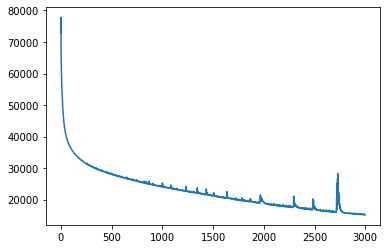

In [58]:
plt.plot(losses)

In [59]:
x_hat = autoencoder(x)

In [60]:
((x - x_hat)**2).sum()

tensor(15215.3760, device='cuda:0', grad_fn=<SumBackward0>)

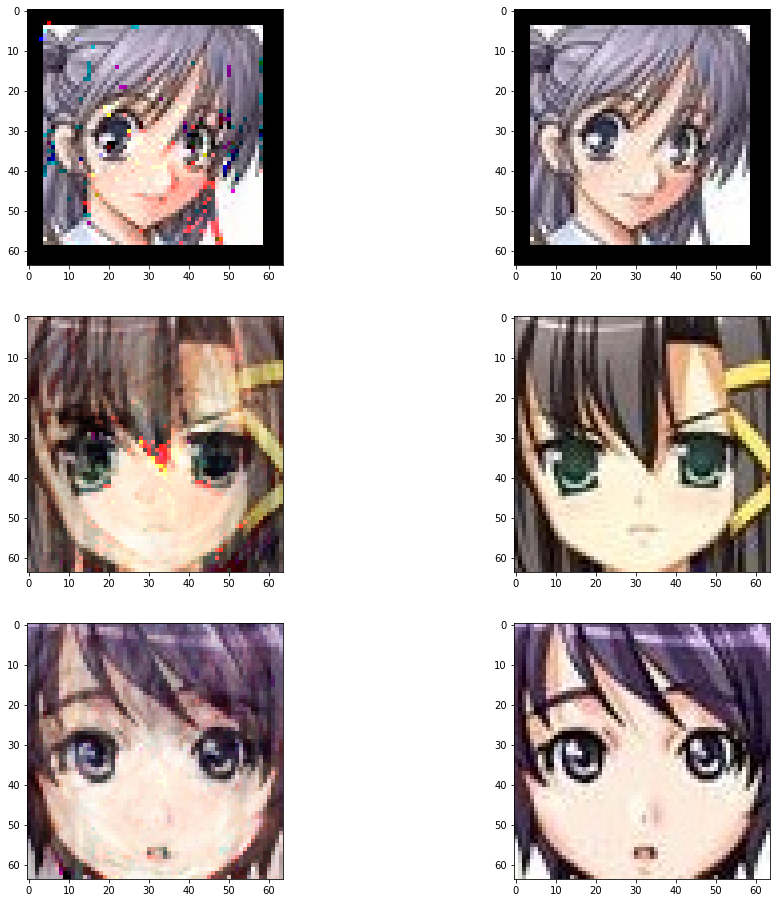

In [61]:
w = 10
h = 10
fig = plt.figure(figsize=(16, 16))
columns = 2
rows = 3

for i in range(1, rows+1):
    fig.add_subplot(rows, columns, i*2 - 1)
    imshow(x_hat[i].cpu().detach())

    fig.add_subplot(rows, columns, i*2)
    imshow(x[i].cpu().detach())
    
plt.show()

In [62]:
losses = ((x_hat - x)**2).sum(dim=(1,2,3))
losses.shape

torch.Size([64])

In [63]:
worst = losses.argmax().item()

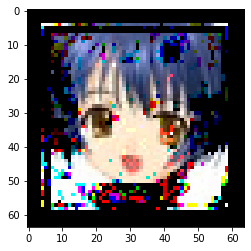

In [64]:
imshow(x_hat[worst].cpu().detach())

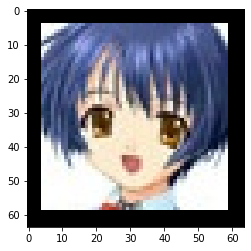

In [65]:
imshow(x[worst].cpu().detach())

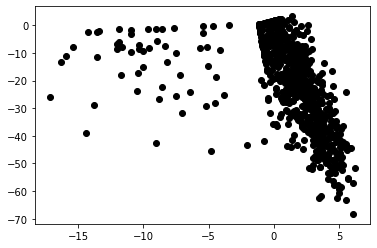

In [66]:
def plot_latent(autoencoder, data, num_batches=10):
    for i, x in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c='black')
        if i > num_batches:
            break


plot_latent(autoencoder, data)

In [67]:
def func(x, y):
    imshow(autoencoder.decoder(torch.Tensor([x,y]).to(device)).cpu().detach().squeeze())
    plt.show()

In [68]:
from ipywidgets import interact
interact(func, x=-5., y=40)

interactive(children=(FloatSlider(value=-5.0, description='x', max=5.0, min=-15.0), IntSlider(value=40, descri…

<function __main__.func(x, y)>